# Bước 1: Import thư viện

51603024_ Hoàng Quốc Bảo

51800009_ Nguuyễn Văn Anh

In [ ]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# Bước 2: Đọc dữ liệu

In [ ]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/PSC.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Đóng cửa        Mở       Cao      Thấp
0     30/12/2022  13,500.0  13,100.0  13,500.0  13,100.0
1     29/12/2022  14,500.0  14,700.0  14,700.0  14,500.0
2     28/12/2022  14,400.0  14,400.0  14,400.0  14,400.0
3     27/12/2022  14,000.0  14,000.0  14,000.0  14,000.0
4     26/12/2022  13,200.0  13,200.0  13,200.0  13,200.0
...          ...       ...       ...       ...       ...
1070  14/02/2012   4,276.0   4,276.0   4,276.0   4,276.0
1071  13/02/2012   4,061.0   4,061.0   4,061.0   4,061.0
1072  10/02/2012   3,953.0   3,917.0   3,953.0   3,917.0
1073  10/01/2012   3,809.0   3,809.0   3,809.0   3,809.0
1074  05/01/2012   3,809.0   3,809.0   3,809.0   3,809.0

[1075 rows x 5 columns]


# Bước 3: Mô tả dữ liệu

In [ ]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [ ]:
#kích thước dữ liệu
df.shape

(1075, 5)

In [ ]:
#dữ liệu 5 dòng đầu
df.head()

,Ngày,Đóng cửa,Mở,Cao,Thấp
0,2022-12-30,"13,500.0","13,100.0","13,500.0","13,100.0"
1,2022-12-29,"14,500.0","14,700.0","14,700.0","14,500.0"
2,2022-12-28,"14,400.0","14,400.0","14,400.0","14,400.0"
3,2022-12-27,"14,000.0","14,000.0","14,000.0","14,000.0"
4,2022-12-26,"13,200.0","13,200.0","13,200.0","13,200.0"


In [ ]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Ngày      1075 non-null   datetime64[ns]
 1   Đóng cửa  1075 non-null   object        
 2   Mở        1075 non-null   object        
 3   Cao       1075 non-null   object        
 4   Thấp      1075 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 42.1+ KB


In [ ]:
#mô tả bộ dữ liệu
df.describe()

<ipython-input-8-36b00b1f613d>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Ngày,Đóng cửa,Mở,Cao,Thấp
count,1075,1075,1075,1075,1075
unique,1075,321,340,328,322
top,2022-12-30 00:00:00,"7,618.0","13,500.0","7,618.0","13,500.0"
freq,1,35,31,31,34
first,2012-01-05 00:00:00,NaN,NaN,NaN,NaN
last,2022-12-30 00:00:00,NaN,NaN,NaN,NaN


# Bước 4: Tiền xử lý dữ liệu

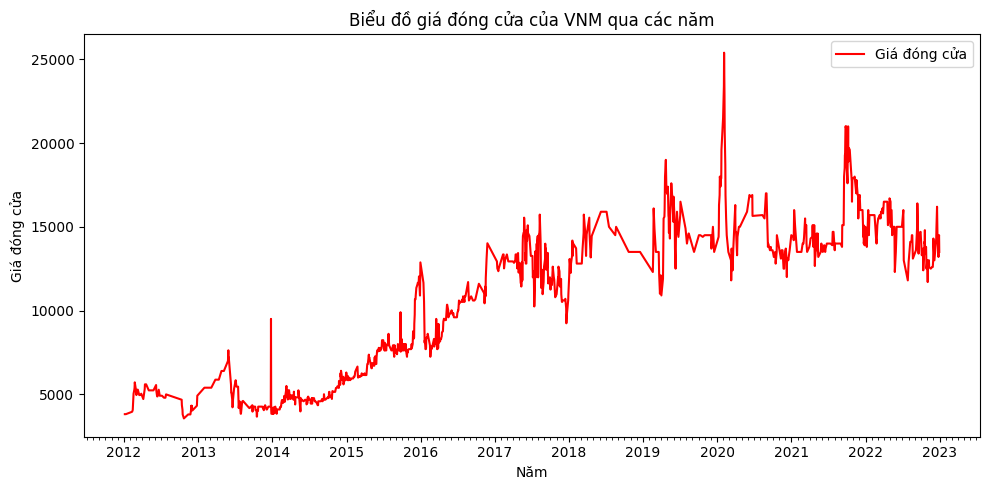

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Đóng cửa'] = df['Đóng cửa'].str.replace(',', '').astype(float)
df['Mở'] = df['Mở'].str.replace(',', '').astype(float)
df['Cao'] = df['Cao'].str.replace(',', '').astype(float)
df['Thấp'] = df['Thấp'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Đóng cửa'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()


In [ ]:
df1 = pd.DataFrame(df,columns=['Ngày','Đóng cửa'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Đóng cửa
Ngày,
2012-01-05,3809.0
2012-01-10,3809.0
2012-02-10,3953.0
2012-02-13,4061.0
2012-02-14,4276.0
...,...
2022-12-26,13200.0
2022-12-27,14000.0
2022-12-28,14400.0


In [ ]:
#chia tập dữ liệu
data = df1.values
train_data = data[:663]
test_data = data[663:]

In [ ]:
data

array([[ 3809.],
       [ 3809.],
       [ 3953.],
       ...,
       [14400.],
       [14500.],
       [13500.]])

In [ ]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [ ]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau


In [ ]:
x_train

[array([0.01167262, 0.01167262, 0.01826421, 0.02320791, 0.03304953,
        0.04623272, 0.05447221, 0.06760963, 0.07914492, 0.08404285,
        0.09869084, 0.08042662, 0.06394763, 0.07859562, 0.07859562,
        0.06394763, 0.06394763, 0.06394763, 0.06760963, 0.05300742,
        0.06760963, 0.08042662, 0.09319784, 0.09319784, 0.07676463,
        0.07676463, 0.07676463, 0.07676463, 0.07676463, 0.07676463,
        0.07676463, 0.09136684, 0.07676463, 0.06028564, 0.06028564,
        0.07493363, 0.07859562, 0.06211663, 0.06211663, 0.05662364,
        0.05662364, 0.06577863, 0.05117642, 0.03652843, 0.02375721,
        0.01094022, 0.        , 0.01094022, 0.01094022, 0.02192621]),
 array([0.01167262, 0.01826421, 0.02320791, 0.03304953, 0.04623272,
        0.05447221, 0.06760963, 0.07914492, 0.08404285, 0.09869084,
        0.08042662, 0.06394763, 0.07859562, 0.07859562, 0.06394763,
        0.06394763, 0.06394763, 0.06760963, 0.05300742, 0.06760963,
        0.08042662, 0.09319784, 0.09319784, 0.

In [ ]:
y_train

[0.034697427446672174,
 0.021926210747963026,
 0.034697427446672174,
 0.021926210747963026,
 0.034697427446672174,
 0.04751441911562759,
 0.06211663462418751,
 0.08404284537215051,
 0.08404284537215051,
 0.08404284537215051,
 0.10601483109035978,
 0.10601483109035978,
 0.12977204064817358,
 0.12977204064817358,
 0.12977204064817358,
 0.1570539229149501,
 0.1863041289023162,
 0.1589764716652934,
 0.16680399157740547,
 0.13952210931062894,
 0.1200219719857182,
 0.09269431474869541,
 0.07127162867344136,
 0.07127162867344136,
 0.051771491348530624,
 0.030303030303030304,
 0.032271354023619886,
 0.051771491348530624,
 0.07319417742378467,
 0.08102169733589673,
 0.10441270713174036,
 0.0868808935274192,
 0.0868808935274192,
 0.06348988373157557,
 0.04398974640666484,
 0.028380481552686992,
 0.04591229515700815,
 0.04591229515700815,
 0.04591229515700815,
 0.030303030303030304,
 0.012771216698709148,
 0.012771216698709148,
 0.030303030303030304,
 0.04591229515700815,
 0.04788061887759773,
 0

In [ ]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

# Bước 5: Xây dựng và huấn luyện mô hình

In [ ]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

In [ ]:
#huấn luyện mô hình
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2)

Epoch 1/100
13/13 - 6s - loss: 0.0687 - 6s/epoch - 429ms/step
Epoch 2/100
13/13 - 0s - loss: 0.0375 - 122ms/epoch - 9ms/step
Epoch 3/100
13/13 - 0s - loss: 0.0352 - 102ms/epoch - 8ms/step
Epoch 4/100
13/13 - 0s - loss: 0.0322 - 98ms/epoch - 8ms/step
Epoch 5/100
13/13 - 0s - loss: 0.0327 - 89ms/epoch - 7ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0348 - 88ms/epoch - 7ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0306 - 88ms/epoch - 7ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0288 - 90ms/epoch - 7ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0321 - 110ms/epoch - 8ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0297 - 131ms/epoch - 10ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0303 - 140ms/epoch - 11ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0292 - 122ms/epoch - 9ms/step
Epoch 13/100
13/13 - 0s - loss: 0.0291 - 118ms/epoch - 9ms/step
Epoch 14/100
13/13 - 0s - loss: 0.0308 - 126ms/epoch - 10ms/step
Epoch 15/100
13/13 - 0s - loss: 0.0279 - 122ms/epoch - 9ms/step
Epoch 16/100
13/13 - 0s - loss: 0.0282 - 116ms/epoch

In [ ]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
#dự đoán giá đóng cửa trên tập đã train
y_train_predict = model.predict(x_train)
#giá dự đoán
y_train_predict = sc.inverse_transform(y_train_predict)


20/20 [==============================] - 2s 45ms/step


# Bước 6: Xử lý dữ liệu test

In [ ]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
#print(x_test.shape)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[663:] #giá thực
y_test_predict = model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

13/13 [==============================] - 0s 4ms/step


# Độ chính xác của mô hình

<ipython-input-22-d094c8486be2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-22-d094c8486be2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


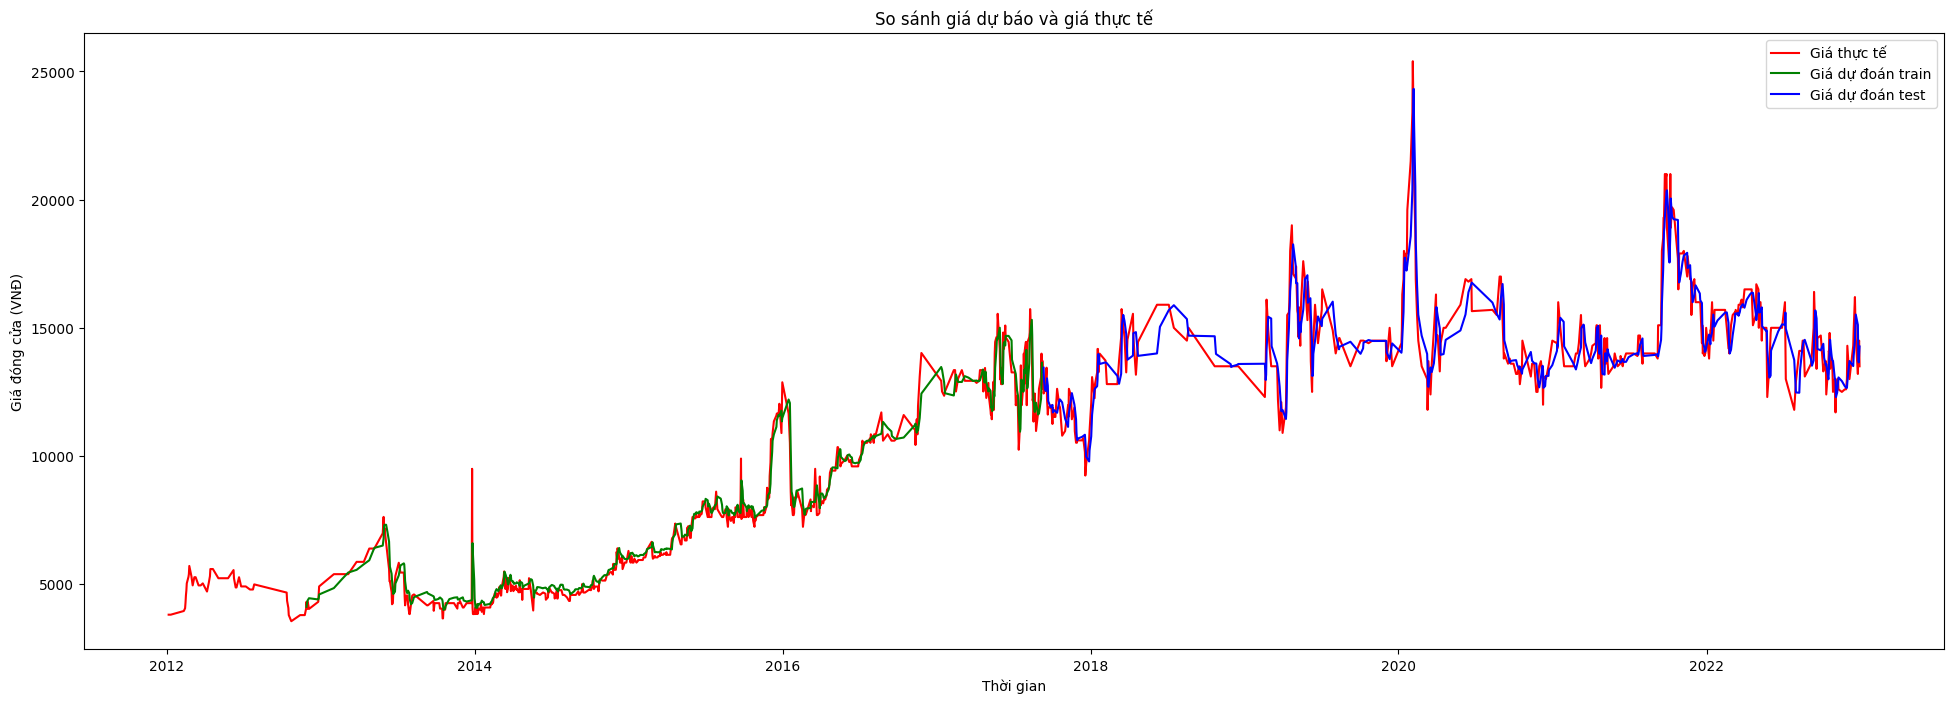

In [ ]:
#lập biểu đồ so sánh
train_data1 = df1[50:663]
test_data1 = df1[663:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [ ]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9688965050271237
Sai số tuyệt đối trung bình trên tập train (VNĐ): 359.691085242914
Phần trăm sai số tuyệt đối trung bình tập train: 0.04999629240214388


In [ ]:
train_data1

,Đóng cửa,Dự đoán
Ngày,,
2012-11-27,4312.0,4116.004883
2012-11-29,4033.0,4327.877930
2012-11-30,4312.0,4369.731445
2012-12-03,4033.0,4451.736328
2012-12-25,4312.0,4402.456055
...,...,...
2017-08-31,12621.0,11659.597656
2017-09-05,13078.0,12239.422852
2017-09-06,13993.0,12867.272461


In [ ]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.8101946479941695
Sai số tuyệt đối trung bình trên tập test (VNĐ): 730.9681005385315
Phần trăm sai số tuyệt đối trung bình tập test: 0.04967812019913407


In [ ]:
test_data1

,Đóng cửa,Dự đoán
Ngày,,
2017-09-11,12438.0,13443.071289
2017-09-12,12529.0,12930.684570
2017-09-14,12621.0,12614.027344
2017-09-15,12529.0,12552.811523
2017-09-18,13444.0,12540.781250
...,...,...
2022-12-26,13200.0,15114.510742
2022-12-27,14000.0,13910.859375
2022-12-28,14400.0,13652.816406


# Thử dự đoán giá tương lai và so sánh với giá ngày cuối

1/1 [==============================] - 0s 158ms/step


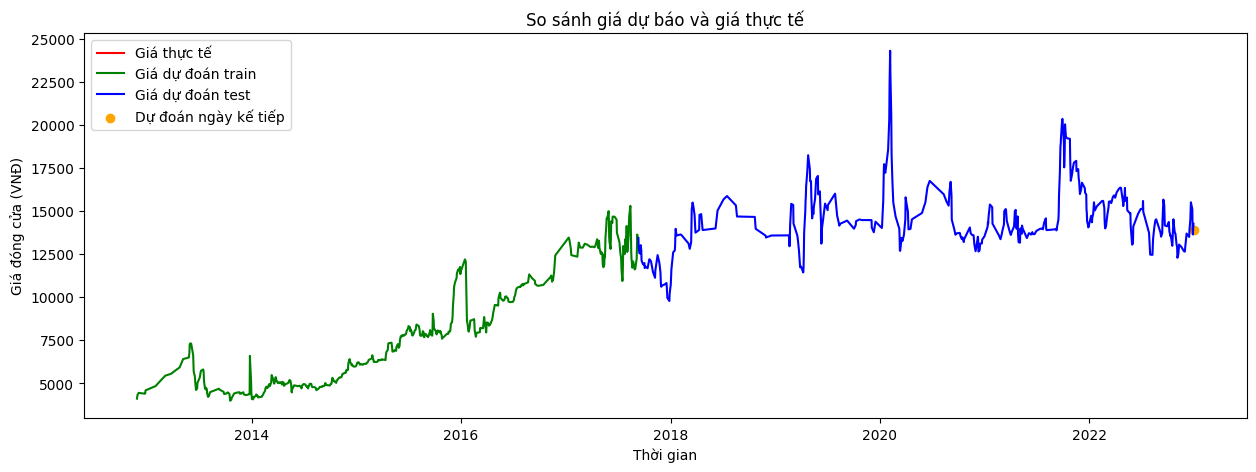

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [ ]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Đóng cửa'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày   Giá dự đoán  Giá ngày trước
0 2022-12-31  13898.458984         13500.0


In [ ]:
# Thêm thư viện và mô hình Feed Forward Neural Network vào dự đoán

from sklearn.neural_network import MLPRegressor

# Tạo mô hình 1 Feed Forward Neural Network mới với L2 regularization alpha=0.01, solver='adam'
nn_model = MLPRegressor(hidden_layer_sizes=(100, 100), alpha=0.01, solver='adam')

# Huấn luyện mô hình Feed Forward Neural Network trên tập huấn luyện
x_train = np.squeeze(x_train)
y_train = np.squeeze(y_train)
nn_model.fit(x_train, y_train)

# Dự đoán trên tập huấn luyện và tập kiểm tra
y_train_nn_predict = nn_model.predict(x_train)
x_test = np.squeeze(x_test)
y_test_nn_predict = nn_model.predict(x_test)

# Đánh giá kết quả trên tập huấn luyện
print('Độ phù hợp tập train (Feed Forward Neural Network):', r2_score(y_train, y_train_nn_predict))
print('Sai số tuyệt đối trung bình trên tập train (VNĐ) (Feed Forward Neural Network):', mean_absolute_error(y_train, y_train_nn_predict))
print('Phần trăm sai số tuyệt đối trung bình tập train (Feed Forward Neural Network):', mean_absolute_percentage_error(y_train, y_train_nn_predict))

# Đánh giá kết quả trên tập kiểm tra
print('Độ phù hợp tập test (Feed Forward Neural Network):', r2_score(y_test, y_test_nn_predict))
print('Sai số tuyệt đối trung bình trên tập test (VNĐ) (Feed Forward Neural Network):', mean_absolute_error(y_test, y_test_nn_predict))
print('Phần trăm sai số tuyệt đối trung bình tập test (Feed Forward Neural Network):', mean_absolute_percentage_error(y_test, y_test_nn_predict))

Độ phù hợp tập train (Feed Forward Neural Network): 0.6671729427857048
Sai số tuyệt đối trung bình trên tập train (VNĐ) (Feed Forward Neural Network): 1517.2985794011413
Phần trăm sai số tuyệt đối trung bình tập train (Feed Forward Neural Network): 0.23635797560874522
Độ phù hợp tập test (Feed Forward Neural Network): -2.2752693305769487
Sai số tuyệt đối trung bình trên tập test (VNĐ) (Feed Forward Neural Network): 3456.8046287731777
Phần trăm sai số tuyệt đối trung bình tập test (Feed Forward Neural Network): 0.2474930445432621


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Import thư viện Linear Regression
from sklearn.linear_model import LinearRegression

# Tạo mô hình Linear Regression
lr = LinearRegression()

# Huấn luyện mô hình Linear Regression trên tập dữ liệu
x_train = np.squeeze(x_train)
y_train = np.squeeze(y_train)
lr.fit(x_train, y_train)

# Dự đoán giá đóng cửa của ngày kế tiếp
x_test = np.squeeze(x_test)
y_test_predict_lr = lr.predict(x_test)
y_train_predict_lr = lr.predict(x_train)
# So sánh kết quả dự đoán với giá thực tế
print('Độ phù hợp tập test:', r2_score(y_test, y_test_predict_lr))
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict_lr))
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(y_test, y_test_predict_lr))

print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict_lr))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict_lr))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict_lr))



Độ phù hợp tập test: 0.7947566180870343
Sai số tuyệt đối trung bình trên tập test (VNĐ): 772.9295444351408
Phần trăm sai số tuyệt đối trung bình tập test: 0.052987669436242155
Độ phù hợp tập train: 0.9753628561360622
Sai số tuyệt đối trung bình trên tập train (VNĐ): 303.40561617533155
Phần trăm sai số tuyệt đối trung bình tập train: 0.040708049727011496


In [ ]:
# Import thư viện Random Forests
from sklearn.ensemble import RandomForestRegressor

# Tạo mô hình Random Forests
rf_model = RandomForestRegressor(n_estimators=100)

# Huấn luyện mô hình
x_train = np.squeeze(x_train)
y_train = np.squeeze(y_train)
rf_model.fit(x_train, y_train)

# Dự đoán trên tập huấn luyện và tập kiểm tra
y_train_rf_predict = rf_model.predict(x_train)
y_test_rf_predict = rf_model.predict(x_test)

# Đánh giá kết quả trên tập huấn luyện
print('Độ phù hợp tập train (Random Forest):', r2_score(y_train, y_train_rf_predict))
print('Sai số tuyệt đối trung bình trên tập train (VNĐ) (Random Forest):', mean_absolute_error(y_train, y_train_rf_predict))
print('Phần trăm sai số tuyệt đối trung bình tập train (Random Forest):', mean_absolute_percentage_error(y_train, y_train_rf_predict))

# Đánh giá kết quả trên tập kiểm tra
print('Độ phù hợp tập test (Random Forest):', r2_score(y_test, y_test_rf_predict))
print('Sai số tuyệt đối trung bình trên tập test (VNĐ) (Random Forest):', mean_absolute_error(y_test, y_test_rf_predict))
print('Phần trăm sai số tuyệt đối trung bình tập test (Random Forest):', mean_absolute_percentage_error(y_test, y_test_rf_predict))

Độ phù hợp tập train (Random Forest): 0.9953621814192871
Sai số tuyệt đối trung bình trên tập train (VNĐ) (Random Forest): 124.00096247960855
Phần trăm sai số tuyệt đối trung bình tập train (Random Forest): 0.01617349831689575
Độ phù hợp tập test (Random Forest): 0.04284231996555632
Sai số tuyệt đối trung bình trên tập test (VNĐ) (Random Forest): 1451.9703398058252
Phần trăm sai số tuyệt đối trung bình tập test (Random Forest): 0.09091355557587863


In [ ]:
# Thêm thư viện và mô hình AdaBoost vào dự đoán

# Import thư viện AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Tạo mô hình AdaBoostRegressor
ab = AdaBoostRegressor(n_estimators=100, learning_rate=0.01)

# Huấn luyện mô hình trên tập dữ liệu
ab.fit(x_train, y_train)

# Dự đoán giá đóng cửa trên tập dữ liệu test
y_test_predict_ab = ab.predict(x_test)
y_train_predict_ab = ab.predict(x_train)
# So sánh kết quả dự đoán với giá thực tế
print('Độ phù hợp tập test:', r2_score(y_test, y_test_predict_ab))
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict_ab))
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(y_test, y_test_predict_ab))
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict_ab))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict_ab))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict_ab))


Độ phù hợp tập test: 0.17894478283626403
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1320.5709943767836
Phần trăm sai số tuyệt đối trung bình tập test: 0.08262378624326623
Độ phù hợp tập train: 0.971418164364796
Sai số tuyệt đối trung bình trên tập train (VNĐ): 368.5773881611256
Phần trăm sai số tuyệt đối trung bình tập train: 0.05251935305844992


In [ ]:
#  Thêm thư viện và mô hình Gradient boosting vào dự đoán

# Import thư viện Gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

# Tạo mô hình Gradient boosting giảm overfitting max_depth=3, subsample=0.8
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, subsample=0.8)

# Huấn luyện mô hình trên tập dữ liệu
gb.fit(x_train, y_train)

# Dự đoán giá đóng cửa trên tập dữ liệu test
y_test_predict_gb = gb.predict(x_test)
y_train_predict_gb = gb.predict(x_train)
# So sánh giá dự đoán với giá thực tế
print('Độ phù hợp tập test:', r2_score(y_test, y_test_predict_gb))
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict_gb))
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(y_test, y_test_predict_gb))
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict_gb))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict_gb))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict_gb))


Độ phù hợp tập test: -1.9220430412404603
Sai số tuyệt đối trung bình trên tập test (VNĐ): 3196.640114665158
Phần trăm sai số tuyệt đối trung bình tập test: 0.20725124343283738
Độ phù hợp tập train: 0.8438238980272488
Sai số tuyệt đối trung bình trên tập train (VNĐ): 987.8738014372409
Phần trăm sai số tuyệt đối trung bình tập train: 0.14620136916169374
